In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd

# Define device

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define transformations

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load datasets

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_dataset = datasets.ImageFolder("/content/drive/MyDrive/Dataset/train", transform=transform)
valid_dataset = datasets.ImageFolder("/content/drive/MyDrive/Dataset/valid", transform=transform)
test_dataset = datasets.ImageFolder("/content/drive/MyDrive/Dataset/test", transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)


# Define model architectures

In [ ]:
model_dict = {
    "ResNet50": models.resnet50(pretrained=True),
    "VGG16": models.vgg16(pretrained=True),
    "DenseNet121": models.densenet121(pretrained=True),
    "MobileNetV2": models.mobilenet_v2(pretrained=True),
    "AlexNet": models.alexnet(pretrained=True)
}

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 192MB/s]
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed i

In [ ]:
num_classes = len(train_dataset.classes)

# Modify models for classification

In [ ]:
def modify_model(model, model_name):
    if model_name.startswith("ResNet"):
        model.fc = nn.Linear(model.fc.in_features, num_classes)
    elif model_name.startswith("VGG") or model_name.startswith("AlexNet"):
        model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)
    elif model_name.startswith("DenseNet"):
        model.classifier = nn.Linear(model.classifier.in_features, num_classes)
    elif model_name.startswith("MobileNet"):
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    return model

In [ ]:
results = {}

# Train and evaluate models

In [ ]:
def train_and_evaluate(model, model_name, epochs=20):
    model = modify_model(model, model_name).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001)

    best_acc = 0.0
    history = {"train_loss": [], "train_acc": [], "valid_loss": [], "valid_acc": []}

    for epoch in range(epochs):
        model.train()
        running_loss, correct = 0.0, 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            correct += (outputs.argmax(dim=1) == labels).sum().item()

        train_loss = running_loss / len(train_loader.dataset)
        train_acc = correct / len(train_loader.dataset)

        model.eval()
        running_loss, correct = 0.0, 0
        with torch.no_grad():
            for inputs, labels in valid_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_loss += loss.item() * inputs.size(0)
                correct += (outputs.argmax(dim=1) == labels).sum().item()

        valid_loss = running_loss / len(valid_loader.dataset)
        valid_acc = correct / len(valid_loader.dataset)

        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["valid_loss"].append(valid_loss)
        history["valid_acc"].append(valid_acc)

        if valid_acc > best_acc:
            best_acc = valid_acc
            torch.save(model.state_dict(), f"best_{model_name}.pth")

        print(f"{model_name} - Epoch {epoch+1}: Train Acc={train_acc*100:.2f}%, Valid Acc={valid_acc*100:.2f}%")

    # Plot accuracy and loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history["train_acc"], label="Train Accuracy")
    plt.plot(history["valid_acc"], label="Valid Accuracy")
    plt.title(f"Accuracy - {model_name}")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history["train_loss"], label="Train Loss")
    plt.plot(history["valid_loss"], label="Valid Loss")
    plt.title(f"Loss - {model_name}")
    plt.legend()
    plt.show()

    # Evaluate on test set
    model.load_state_dict(torch.load(f"best_{model_name}.pth"))
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = outputs.argmax(dim=1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    cm = confusion_matrix(y_true, y_pred)
    print(f"{model_name} Classification Report:\n",
          classification_report(y_true, y_pred, target_names=train_dataset.classes))
    plt.figure(figsize=(6,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()

    results[model_name] = best_acc

# Train all models

ResNet50 - Epoch 1: Train Acc=71.94%, Valid Acc=73.61%
ResNet50 - Epoch 2: Train Acc=98.04%, Valid Acc=84.72%
ResNet50 - Epoch 3: Train Acc=98.53%, Valid Acc=94.44%
ResNet50 - Epoch 4: Train Acc=99.02%, Valid Acc=87.50%
ResNet50 - Epoch 5: Train Acc=99.02%, Valid Acc=91.67%
ResNet50 - Epoch 6: Train Acc=98.21%, Valid Acc=91.67%
ResNet50 - Epoch 7: Train Acc=99.35%, Valid Acc=80.56%
ResNet50 - Epoch 8: Train Acc=98.86%, Valid Acc=95.83%
ResNet50 - Epoch 9: Train Acc=97.72%, Valid Acc=80.56%
ResNet50 - Epoch 10: Train Acc=99.35%, Valid Acc=86.11%
ResNet50 - Epoch 11: Train Acc=99.67%, Valid Acc=93.06%
ResNet50 - Epoch 12: Train Acc=99.84%, Valid Acc=91.67%
ResNet50 - Epoch 13: Train Acc=99.67%, Valid Acc=91.67%
ResNet50 - Epoch 14: Train Acc=99.51%, Valid Acc=88.89%
ResNet50 - Epoch 15: Train Acc=99.84%, Valid Acc=93.06%
ResNet50 - Epoch 16: Train Acc=99.67%, Valid Acc=91.67%
ResNet50 - Epoch 17: Train Acc=98.37%, Valid Acc=65.28%
ResNet50 - Epoch 18: Train Acc=99.02%, Valid Acc=84.72%
R

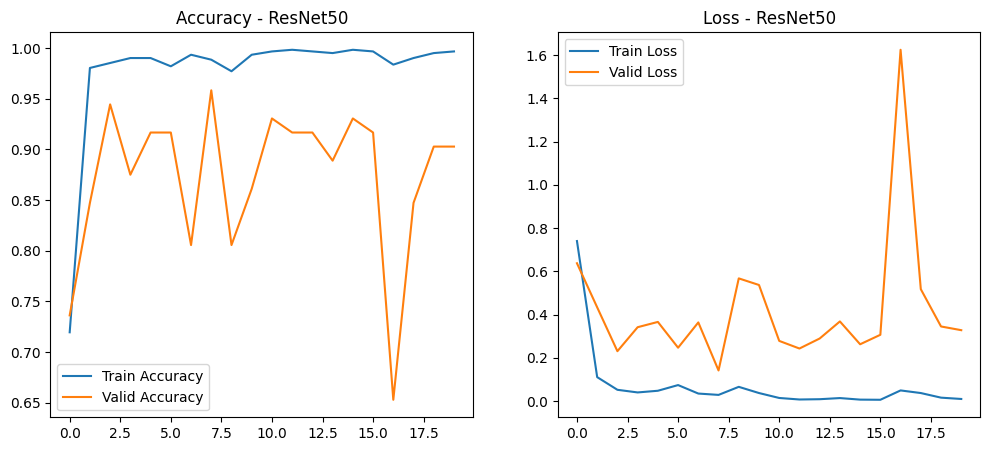

ResNet50 Classification Report:
                          precision    recall  f1-score   support

         Adenocarcinoma       0.88      0.93      0.91       120
   Large cell carcinoma       0.67      0.98      0.79        51
                 Normal       1.00      0.98      0.99        54
Squamous cell carcinoma       0.98      0.66      0.79        90

               accuracy                           0.87       315
              macro avg       0.88      0.89      0.87       315
           weighted avg       0.90      0.87      0.87       315



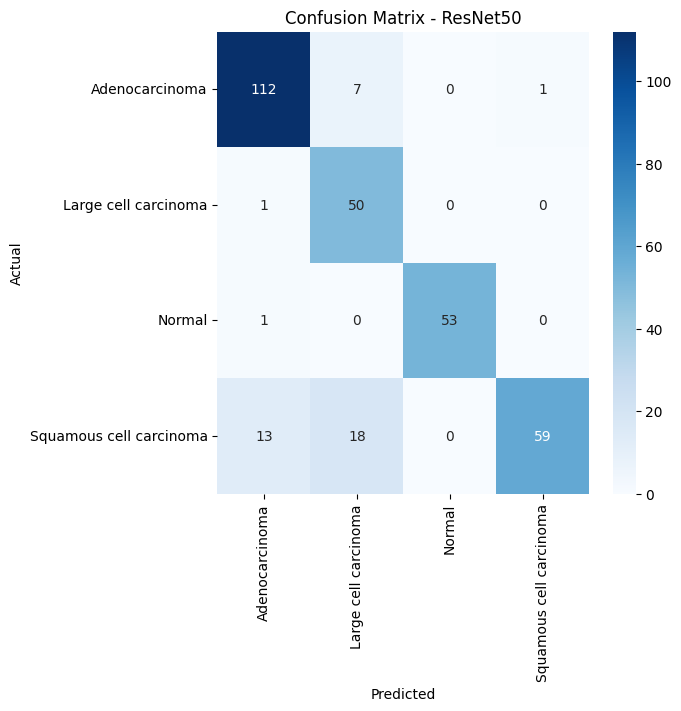

VGG16 - Epoch 1: Train Acc=54.00%, Valid Acc=55.56%
VGG16 - Epoch 2: Train Acc=76.84%, Valid Acc=83.33%
VGG16 - Epoch 3: Train Acc=93.80%, Valid Acc=77.78%
VGG16 - Epoch 4: Train Acc=95.43%, Valid Acc=90.28%
VGG16 - Epoch 5: Train Acc=99.18%, Valid Acc=84.72%
VGG16 - Epoch 6: Train Acc=99.84%, Valid Acc=87.50%
VGG16 - Epoch 7: Train Acc=99.84%, Valid Acc=90.28%
VGG16 - Epoch 8: Train Acc=99.84%, Valid Acc=93.06%
VGG16 - Epoch 9: Train Acc=99.84%, Valid Acc=90.28%
VGG16 - Epoch 10: Train Acc=99.67%, Valid Acc=90.28%
VGG16 - Epoch 11: Train Acc=99.67%, Valid Acc=88.89%
VGG16 - Epoch 12: Train Acc=99.67%, Valid Acc=88.89%
VGG16 - Epoch 13: Train Acc=99.84%, Valid Acc=88.89%
VGG16 - Epoch 14: Train Acc=99.84%, Valid Acc=88.89%
VGG16 - Epoch 15: Train Acc=99.67%, Valid Acc=90.28%
VGG16 - Epoch 16: Train Acc=99.67%, Valid Acc=90.28%
VGG16 - Epoch 17: Train Acc=99.84%, Valid Acc=88.89%
VGG16 - Epoch 18: Train Acc=99.67%, Valid Acc=90.28%
VGG16 - Epoch 19: Train Acc=99.84%, Valid Acc=90.28%
VG

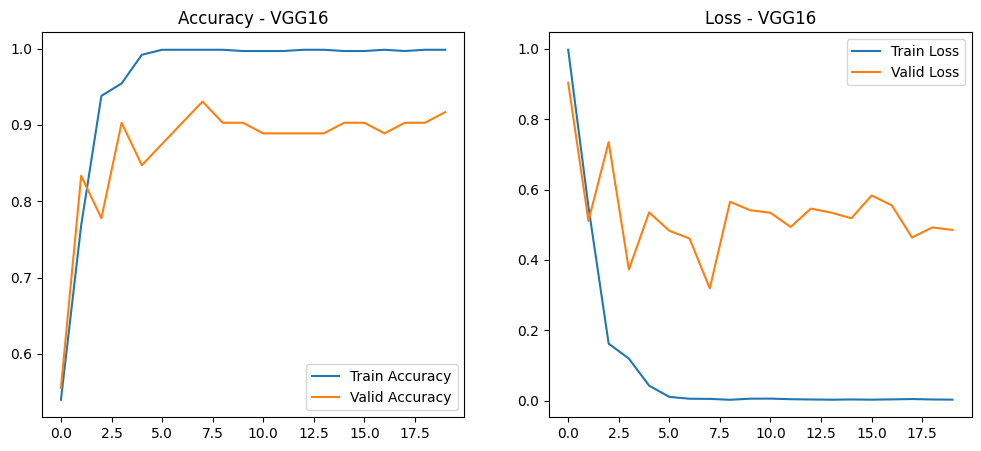

VGG16 Classification Report:
                          precision    recall  f1-score   support

         Adenocarcinoma       0.89      0.69      0.78       120
   Large cell carcinoma       0.76      1.00      0.86        51
                 Normal       1.00      0.98      0.99        54
Squamous cell carcinoma       0.78      0.89      0.83        90

               accuracy                           0.85       315
              macro avg       0.86      0.89      0.87       315
           weighted avg       0.86      0.85      0.84       315



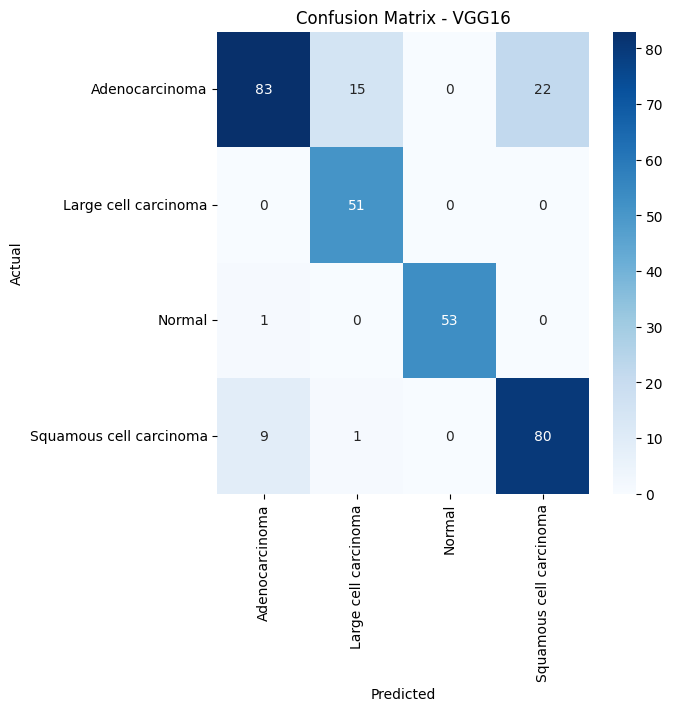

DenseNet121 - Epoch 1: Train Acc=65.74%, Valid Acc=75.00%
DenseNet121 - Epoch 2: Train Acc=97.23%, Valid Acc=84.72%
DenseNet121 - Epoch 3: Train Acc=99.18%, Valid Acc=91.67%
DenseNet121 - Epoch 4: Train Acc=99.84%, Valid Acc=90.28%
DenseNet121 - Epoch 5: Train Acc=99.84%, Valid Acc=91.67%
DenseNet121 - Epoch 6: Train Acc=99.67%, Valid Acc=90.28%
DenseNet121 - Epoch 7: Train Acc=99.84%, Valid Acc=93.06%
DenseNet121 - Epoch 8: Train Acc=99.67%, Valid Acc=94.44%
DenseNet121 - Epoch 9: Train Acc=99.67%, Valid Acc=93.06%
DenseNet121 - Epoch 10: Train Acc=98.37%, Valid Acc=91.67%
DenseNet121 - Epoch 11: Train Acc=98.86%, Valid Acc=90.28%
DenseNet121 - Epoch 12: Train Acc=99.02%, Valid Acc=88.89%
DenseNet121 - Epoch 13: Train Acc=99.18%, Valid Acc=91.67%
DenseNet121 - Epoch 14: Train Acc=99.67%, Valid Acc=93.06%
DenseNet121 - Epoch 15: Train Acc=99.67%, Valid Acc=91.67%
DenseNet121 - Epoch 16: Train Acc=99.84%, Valid Acc=91.67%
DenseNet121 - Epoch 17: Train Acc=99.51%, Valid Acc=91.67%
DenseN

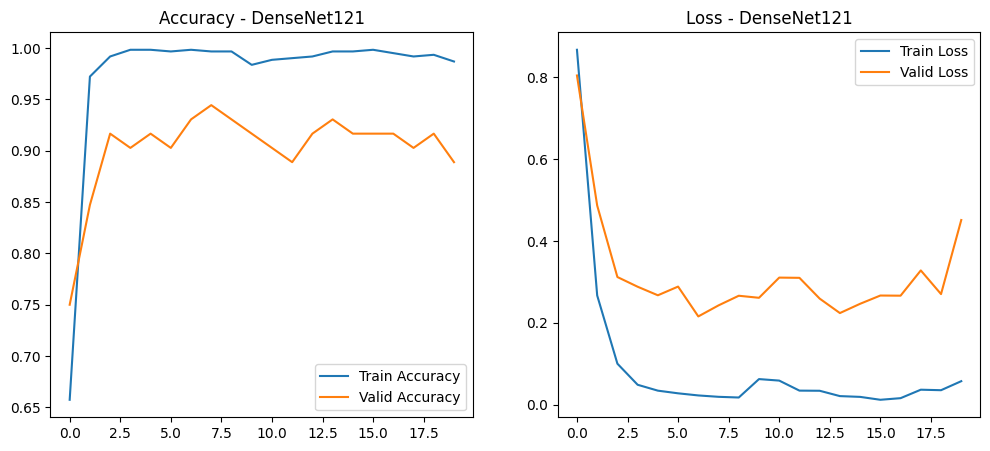

DenseNet121 Classification Report:
                          precision    recall  f1-score   support

         Adenocarcinoma       0.92      0.92      0.92       120
   Large cell carcinoma       0.89      0.96      0.92        51
                 Normal       1.00      0.98      0.99        54
Squamous cell carcinoma       0.94      0.92      0.93        90

               accuracy                           0.94       315
              macro avg       0.94      0.95      0.94       315
           weighted avg       0.94      0.94      0.94       315



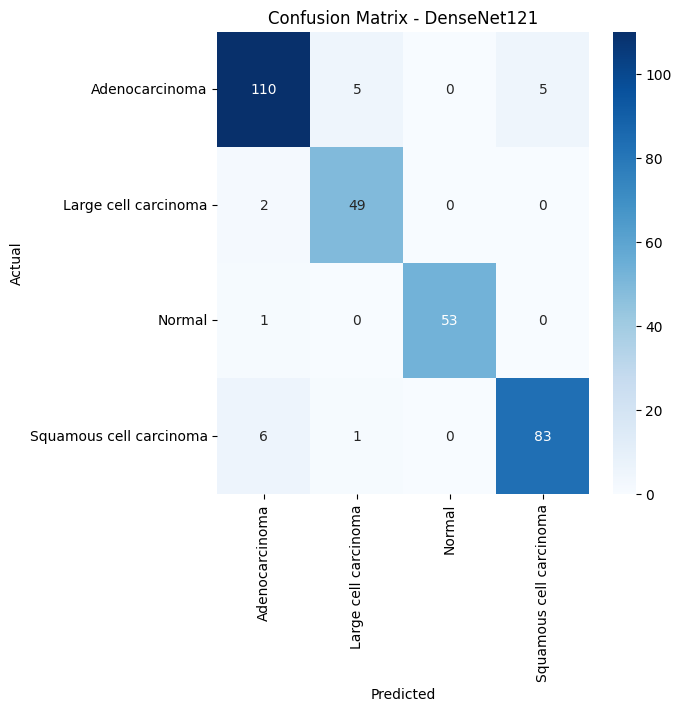

MobileNetV2 - Epoch 1: Train Acc=63.30%, Valid Acc=69.44%
MobileNetV2 - Epoch 2: Train Acc=90.70%, Valid Acc=72.22%
MobileNetV2 - Epoch 3: Train Acc=97.72%, Valid Acc=86.11%
MobileNetV2 - Epoch 4: Train Acc=99.35%, Valid Acc=84.72%
MobileNetV2 - Epoch 5: Train Acc=99.67%, Valid Acc=84.72%
MobileNetV2 - Epoch 6: Train Acc=99.18%, Valid Acc=88.89%
MobileNetV2 - Epoch 7: Train Acc=99.67%, Valid Acc=84.72%
MobileNetV2 - Epoch 8: Train Acc=99.67%, Valid Acc=87.50%
MobileNetV2 - Epoch 9: Train Acc=98.86%, Valid Acc=87.50%
MobileNetV2 - Epoch 10: Train Acc=99.51%, Valid Acc=84.72%
MobileNetV2 - Epoch 11: Train Acc=99.18%, Valid Acc=88.89%
MobileNetV2 - Epoch 12: Train Acc=99.84%, Valid Acc=87.50%
MobileNetV2 - Epoch 13: Train Acc=99.51%, Valid Acc=88.89%
MobileNetV2 - Epoch 14: Train Acc=98.86%, Valid Acc=80.56%
MobileNetV2 - Epoch 15: Train Acc=98.86%, Valid Acc=84.72%
MobileNetV2 - Epoch 16: Train Acc=99.67%, Valid Acc=86.11%
MobileNetV2 - Epoch 17: Train Acc=99.51%, Valid Acc=87.50%
Mobile

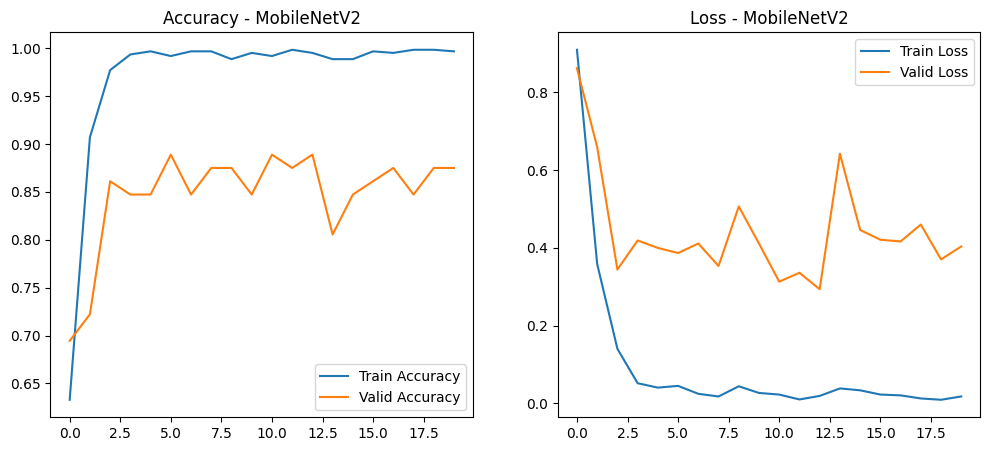

MobileNetV2 Classification Report:
                          precision    recall  f1-score   support

         Adenocarcinoma       0.99      0.65      0.78       120
   Large cell carcinoma       0.65      1.00      0.78        51
                 Normal       1.00      0.98      0.99        54
Squamous cell carcinoma       0.84      0.97      0.90        90

               accuracy                           0.85       315
              macro avg       0.87      0.90      0.86       315
           weighted avg       0.89      0.85      0.85       315



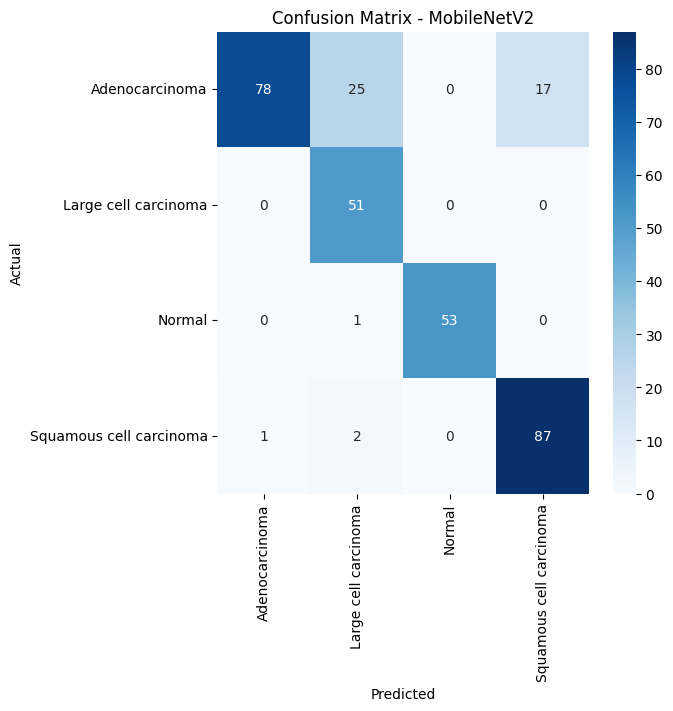

AlexNet - Epoch 1: Train Acc=54.16%, Valid Acc=65.28%
AlexNet - Epoch 2: Train Acc=78.96%, Valid Acc=68.06%
AlexNet - Epoch 3: Train Acc=90.70%, Valid Acc=69.44%
AlexNet - Epoch 4: Train Acc=95.92%, Valid Acc=76.39%
AlexNet - Epoch 5: Train Acc=98.53%, Valid Acc=80.56%
AlexNet - Epoch 6: Train Acc=98.86%, Valid Acc=83.33%
AlexNet - Epoch 7: Train Acc=99.67%, Valid Acc=86.11%
AlexNet - Epoch 8: Train Acc=99.35%, Valid Acc=72.22%
AlexNet - Epoch 9: Train Acc=96.57%, Valid Acc=73.61%
AlexNet - Epoch 10: Train Acc=96.08%, Valid Acc=80.56%
AlexNet - Epoch 11: Train Acc=99.18%, Valid Acc=83.33%
AlexNet - Epoch 12: Train Acc=99.84%, Valid Acc=87.50%
AlexNet - Epoch 13: Train Acc=100.00%, Valid Acc=84.72%
AlexNet - Epoch 14: Train Acc=99.84%, Valid Acc=81.94%
AlexNet - Epoch 15: Train Acc=99.67%, Valid Acc=86.11%
AlexNet - Epoch 16: Train Acc=99.67%, Valid Acc=83.33%
AlexNet - Epoch 17: Train Acc=99.84%, Valid Acc=87.50%
AlexNet - Epoch 18: Train Acc=99.67%, Valid Acc=86.11%
AlexNet - Epoch 19

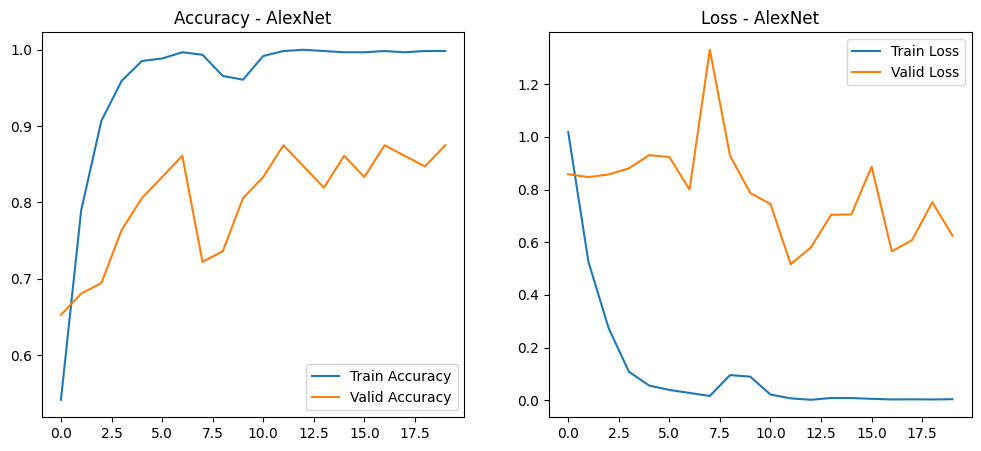

AlexNet Classification Report:
                          precision    recall  f1-score   support

         Adenocarcinoma       0.80      0.89      0.84       120
   Large cell carcinoma       0.68      0.92      0.78        51
                 Normal       1.00      0.96      0.98        54
Squamous cell carcinoma       1.00      0.67      0.80        90

               accuracy                           0.84       315
              macro avg       0.87      0.86      0.85       315
           weighted avg       0.87      0.84      0.84       315



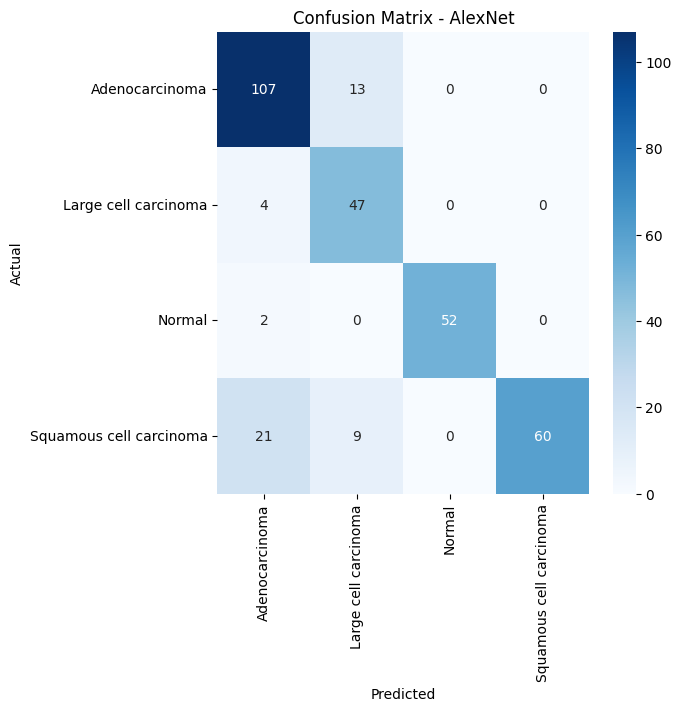

In [ ]:
for name, model in model_dict.items():
    train_and_evaluate(model, name)

# Save best model for deployment

In [ ]:
best_model_name = max(results, key=results.get)
print(f"Best model: {best_model_name} with accuracy {results[best_model_name]*100:.2f}%")
best_model = model_dict[best_model_name]
best_model.load_state_dict(torch.load(f"best_{best_model_name}.pth"))
torch.save(best_model.state_dict(), "best_model.keras")

Best model: ResNet50 with accuracy 95.83%


In [ ]:
# Generate Summary Table
def generate_summary_table(results):
    df = pd.DataFrame.from_dict(results, orient='index', columns=['Test Accuracy'])
    print("\nSummary Table:")
    print(df.sort_values(by='Test Accuracy', ascending=False))
    return df

summary_df = generate_summary_table(results)


Summary Table:
             Test Accuracy
ResNet50          0.958333
DenseNet121       0.944444
VGG16             0.930556
MobileNetV2       0.888889
AlexNet           0.875000


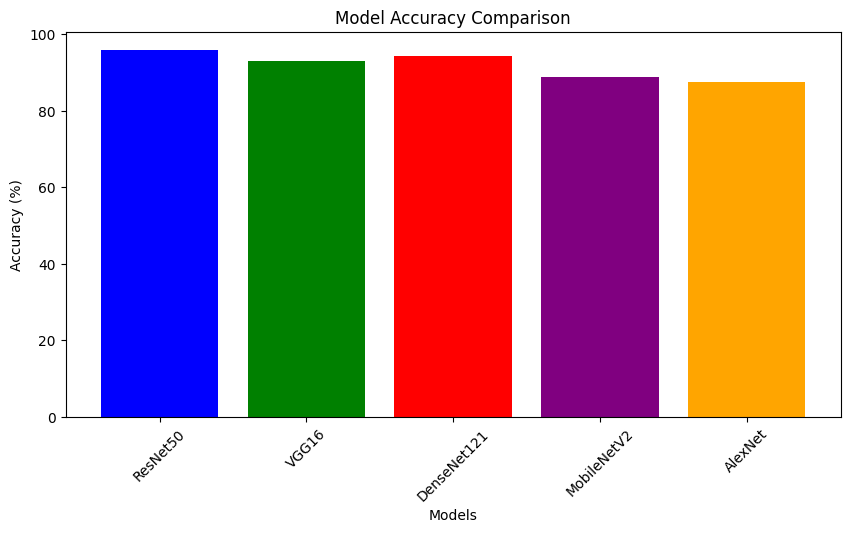

In [ ]:
# Generate Accuracy Bar Graph
plt.figure(figsize=(10,5))
plt.bar(results.keys(), [acc*100 for acc in results.values()], color=['blue', 'green', 'red', 'purple', 'orange'])
plt.xlabel('Models')
plt.ylabel('Accuracy (%)')
plt.title('Model Accuracy Comparison')
plt.xticks(rotation=45)
plt.show()

In [ ]:
import pandas as pd

# Data dictionary
data = {
    "Model": ["ResNet50", "DenseNet121", "VGG16", "MobileNetV2", "AlexNet"],
    "Train Accuracy": [99.67, 99.84, 99.84, 99.84, 99.84],
    "Validation Accuracy": [93.06, 94.44, 91.67, 87.50, 87.50],
    "Test Accuracy": [95.83, 94.44, 93.06, 88.89, 87.50]
}

# Create DataFrame
df = pd.DataFrame(data)
print("Summary Table:")
# Display the table
print(df)

# Save as CSV (optional)
df.to_csv("model_comparison.csv", index=False)


Summary Table:
         Model  Train Accuracy  Validation Accuracy  Test Accuracy
0     ResNet50           99.67                93.06          95.83
1  DenseNet121           99.84                94.44          94.44
2        VGG16           99.84                91.67          93.06
3  MobileNetV2           99.84                87.50          88.89
4      AlexNet           99.84                87.50          87.50
